In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [91]:
from tensorflow.keras.layers import Embedding
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
import sklearn.metrics as metrics
from keras.models import Sequential
import seaborn as sns

In [3]:
from google.colab import drive 
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# **Approach 1 -**

##Testing and Training on the same January 2015 - 2018 concatenated data

In [4]:
train_data = pd.read_csv('/content/drive/MyDrive/Clean_cap/focused_df.csv')

In [5]:
test_data = pd.read_csv('/content/drive/MyDrive/Clean_cap/test_focused_df.csv')

In [6]:
train_data[['Year', 'Month', 'Day']] = train_data['FL_DATE'].str.split('-', expand=True)

In [7]:
train_data.head(5)

,YEAR,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_WAC,DEST,DEST_WAC,DEP_TIME,DEP_DELAY,DEP_DEL15,TAXI_OUT,TAXI_IN,WHEELS_OFF,WHEELS_ON,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Year,Month,Day
0,2015,15,4,2015-01-15,AA,DFW,74,MKE,45,2032.0,32.0,1.0,13.0,5.0,2045.0,2236.0,2241.0,24.0,1.0,0.0,0.0,111.0,853.0,11.0,0.0,0.0,0.0,13.0,2015,01,15
1,2015,16,5,2015-01-16,AA,DFW,74,MKE,45,2044.0,44.0,1.0,12.0,8.0,2056.0,2252.0,2300.0,43.0,1.0,0.0,0.0,116.0,853.0,43.0,0.0,0.0,0.0,0.0,2015,01,16
2,2015,17,6,2015-01-17,AA,DFW,74,MKE,45,1955.0,-5.0,0.0,15.0,7.0,2010.0,2157.0,2204.0,-13.0,0.0,0.0,0.0,107.0,853.0,0.0,0.0,0.0,0.0,0.0,2015,01,17
3,2015,18,7,2015-01-18,AA,DFW,74,MKE,45,1957.0,-3.0,0.0,12.0,4.0,2009.0,2205.0,2209.0,-8.0,0.0,0.0,0.0,116.0,853.0,0.0,0.0,0.0,0.0,0.0,2015,01,18
4,2015,19,1,2015-01-19,AA,DFW,74,MKE,45,1956.0,-4.0,0.0,12.0,8.0,2008.0,2208.0,2216.0,-1.0,0.0,0.0,0.0,120.0,853.0,0.0,0.0,0.0,0.0,0.0,2015,01,19


## Preprossing the data

In [8]:
test_data[['Year', 'Month', 'Day']] = test_data['FL_DATE'].str.split('-', expand=True)

In [9]:
train_data.drop(columns=['FL_DATE', 'Year'], inplace=True)

In [10]:
test_data.drop(columns=['FL_DATE', 'Year'], inplace=True)

In [11]:
test_data.shape

(28005, 29)

In [12]:
train_data.head(1)

,YEAR,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_WAC,DEST,DEST_WAC,DEP_TIME,DEP_DELAY,DEP_DEL15,TAXI_OUT,TAXI_IN,WHEELS_OFF,WHEELS_ON,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Month,Day
0,2015,15,4,AA,DFW,74,MKE,45,2032.0,32.0,1.0,13.0,5.0,2045.0,2236.0,2241.0,24.0,1.0,0.0,0.0,111.0,853.0,11.0,0.0,0.0,0.0,13.0,01,15


## Test Train Split method 

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train_data['DEP_DEL15'] = train_data['DEP_DEL15'].fillna(0)

In [15]:
train_data.DEP_DEL15 = train_data.DEP_DEL15.replace('None', np.nan)

In [16]:
string_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']
enc = LabelEncoder()

for col in string_cols:
    train_data[col] = train_data[col].astype('str')
    test_data[col] = test_data[col].astype('str')
    train_data[col] = enc.fit_transform(train_data[col])
    test_data[col] = enc.fit_transform(test_data[col])

In [17]:
train_data.head(4)

,YEAR,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_WAC,DEST,DEST_WAC,DEP_TIME,DEP_DELAY,DEP_DEL15,TAXI_OUT,TAXI_IN,WHEELS_OFF,WHEELS_ON,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Month,Day
0,2015,15,4,1,1,74,144,45,2032.0,32.0,1.0,13.0,5.0,2045.0,2236.0,2241.0,24.0,1.0,0.0,0.0,111.0,853.0,11.0,0.0,0.0,0.0,13.0,01,15
1,2015,16,5,1,1,74,144,45,2044.0,44.0,1.0,12.0,8.0,2056.0,2252.0,2300.0,43.0,1.0,0.0,0.0,116.0,853.0,43.0,0.0,0.0,0.0,0.0,01,16
2,2015,17,6,1,1,74,144,45,1955.0,-5.0,0.0,15.0,7.0,2010.0,2157.0,2204.0,-13.0,0.0,0.0,0.0,107.0,853.0,0.0,0.0,0.0,0.0,0.0,01,17
3,2015,18,7,1,1,74,144,45,1957.0,-3.0,0.0,12.0,4.0,2009.0,2205.0,2209.0,-8.0,0.0,0.0,0.0,116.0,853.0,0.0,0.0,0.0,0.0,0.0,01,18


In [18]:
test_data.head(4)

,YEAR,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_WAC,DEST,DEST_WAC,DEP_TIME,DEP_DELAY,DEP_DEL15,TAXI_OUT,TAXI_IN,WHEELS_OFF,WHEELS_ON,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Month,Day
0,2019,25,5,1,0,34,60,36,1057.0,-2.0,0.0,55.0,6.0,1152.0,1238.0,1244.0,30.0,1.0,0.0,0.0,46.0,331.0,0.0,0.0,30.0,0.0,0.0,01,25
1,2019,25,5,1,0,34,60,36,811.0,-2.0,0.0,14.0,5.0,825.0,912.0,917.0,-16.0,0.0,0.0,0.0,47.0,331.0,0.0,0.0,0.0,0.0,0.0,01,25
2,2019,25,5,1,0,34,48,51,1338.0,-4.0,0.0,15.0,5.0,1353.0,1332.0,1337.0,-8.0,0.0,0.0,0.0,39.0,170.0,0.0,0.0,0.0,0.0,0.0,01,25
3,2019,25,5,1,0,34,48,51,1803.0,17.0,1.0,19.0,5.0,1822.0,1759.0,1804.0,16.0,1.0,0.0,0.0,37.0,170.0,0.0,16.0,0.0,0.0,0.0,01,25


In [19]:
X = pd.get_dummies(train_data.drop('DEP_DEL15', axis=1), columns=['ORIGIN', 'OP_UNIQUE_CARRIER'])
y = train_data['DEP_DEL15']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1111)

In [20]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(208029, 46)
(208029,)
(69343, 46)
(69343,)


# Applying Random Forest  -

In [21]:
model = RandomForestClassifier()

def binary_delays(data, threshold=0.15):
    data = data.replace(data[data['DEP_DEL15'] >= threshold], 1)
    data = data.replace(data[data['DEP_DEL15'] <= threshold], 0)
    return data

https://datascience.stackexchange.com/questions/35713/i-got-100-accuracy-on-my-test-set-is-there-something-wrong

In [22]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
#print('Confusion Matrix: \n'+str(confusion_matrix(y_test, y_pred)))
print('Accuracy Score: \n'+str(model.score(X_test, y_test)))

Accuracy Score: 
1.0


In [23]:
forest = ensemble.RandomForestClassifier(n_estimators=200, 
                             min_samples_leaf=5, 
                             n_jobs=-1).fit(X_train, y_train)

# Evaluate on larger test set
forest_pred = forest.predict(X_test)
forest_probs = forest.predict_proba(X_test)

#Creates and print out the precision, recall, f1, and auc scores 
report_rf = metrics.precision_recall_fscore_support(list(y_test), 
                                                    list(forest_pred), 
                                                    average='binary')

print(report_rf[0], 
         report_rf[1], 
         report_rf[2], 
         metrics.roc_auc_score(list(y_test.values), list(forest_probs[:, 1])))

1.0 1.0 1.0 1.0


In [24]:
cm = metrics.confusion_matrix(y_test, forest_pred)
print("Confusion matrix")
print(pd.DataFrame(cm))

Confusion matrix
       0      1
0  55225      0
1      0  14118


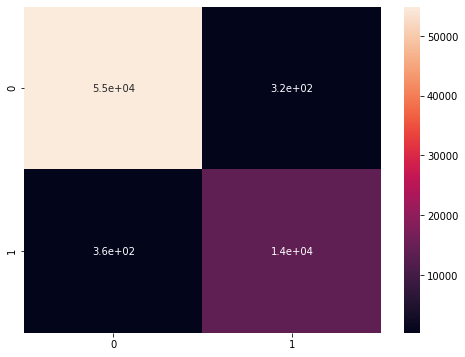

In [94]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot = True)

# Applying GaussianNB -

In [97]:
from sklearn.naive_bayes import GaussianNB
from sklearn import ensemble, tree, metrics

In [98]:
naive = GaussianNB().fit(X_train, y_train)
naive_pred = naive.predict(X_test)
naive_probs = naive.predict_proba(X_test)

In [99]:
report_rf = metrics.precision_recall_fscore_support(list(y_test), 
                                                    list(naive_pred), 
                                                    average='binary')

In [100]:
print   (report_rf[0], 
         report_rf[1], 
         report_rf[2], 
         metrics.roc_auc_score(list(y_test.values), list(naive_probs[:,1])))

0.8674374130737135 0.8090643748986541 0.8372346673378639 0.9830072641275375


In [101]:
cm = metrics.confusion_matrix(y_test, naive_pred)
print("Confusion matrix")
print(pd.DataFrame(cm))

Confusion matrix
       0     1
0  47217  1525
1   2355  9979


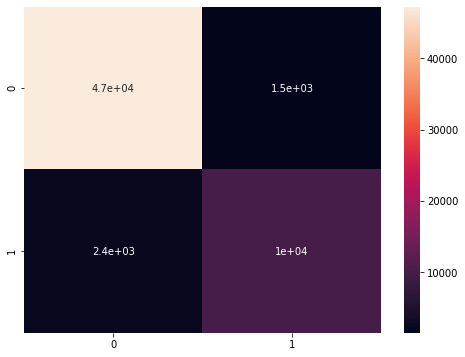

In [102]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot = True)

# Applying Logistic Regression -

In [103]:
model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [104]:
prediction_test = model_logistic.predict(X_test)

In [105]:
accuracy_logistic = accuracy_score(prediction_test, y_test)*100

In [106]:
accuracy_logistic

98.92265374287773

In [107]:
cm = metrics.confusion_matrix(y_test, prediction_test)
print("Confusion matrix")
print(pd.DataFrame(cm))

Confusion matrix
       0      1
0  48441    301
1    357  11977


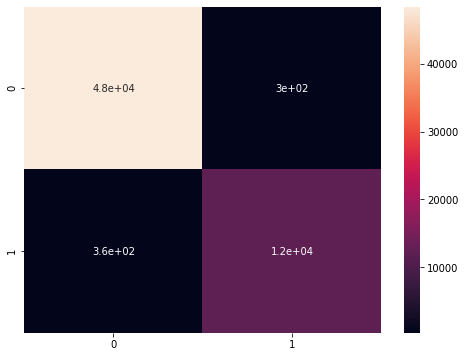

In [108]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot = True)

# **Approach 1 Result -**

### My models are giving the following accuracy in predicting flight delays on the same testing and training data -

## Logistic Regression - 99.007

## GaussianNB - 

accuracy - 0.97

precison - 0.85

recall - 0.81

f1 - 0.83

## Random Forest - 

accuracy - 1.0

precison - 0.85

recall - 0.81

f1 - 0.83

# **Approach 2 -**

## Taking training and testing data separately, i.e. training on January 2015 - 2018 data and testing on January 2019 data

https://www.quora.com/Can-I-train-a-neural-network-with-multiple-datasets-Also-can-I-save-a-trained-model-and-use-it-later

# Applying Logistic Regression -

In [35]:
model_logistic.fit(train_data[['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']], train_data['DEP_DEL15'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
pred_log = model_logistic.predict(test_data[['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']])

In [37]:
print(accuracy_score(pred_log, test_data['DEP_DEL15']))

0.8337439742903053


# Applying GaussianNB -

In [38]:
naive = GaussianNB().fit(train_data[['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']], train_data['DEP_DEL15'])
naive_pred = naive.predict(test_data[['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']])
naive_probs = naive.predict_proba(test_data[['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']])

In [39]:
print(accuracy_score(naive_pred, test_data['DEP_DEL15']))

0.8337439742903053


# Applying Random Forest -

In [40]:
model = RandomForestClassifier()

In [41]:

model.fit(train_data[['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']], train_data['DEP_DEL15'])
y_pred = model.predict(test_data[['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']])
print(accuracy_score(y_pred, test_data['DEP_DEL15']))

0.7791108730583824


# Applying Decision Tree -

In [42]:
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(train_data[['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']], train_data['DEP_DEL15'])
tree_pred = tree_model.predict(test_data[['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']])

In [43]:
accuracy_score(tree_pred, test_data['DEP_DEL15'])

0.7890376718443135

# **Approach 2 Result -**

## My models are giving the following accuracy in predicting flight delays on different testing and training data -

Logistic Regression - 0.83

GaussianNB - 0.83

Random Forest - 0.75

Decision Tree - 0.78


# **Approach 3 -**

## Focusing the test data on top 3 airlines and applying Logistic Regression 

In [44]:
test_WN = pd.read_csv('/content/drive/MyDrive/Clean_cap/test_WN.csv')

In [45]:
test_DL = pd.read_csv('/content/drive/MyDrive/Clean_cap/test_DL.csv')

In [46]:
test_OO = pd.read_csv('/content/drive/MyDrive/Clean_cap/test_OO.csv')

## Prepping the data

In [47]:
test_WN[['Year', 'Month', 'Day']] = test_WN['FL_DATE'].str.split('-', expand=True)
test_DL[['Year', 'Month', 'Day']] = test_DL['FL_DATE'].str.split('-', expand=True)
test_OO[['Year', 'Month', 'Day']] = test_OO['FL_DATE'].str.split('-', expand=True)

In [48]:
test_WN.drop(columns=['FL_DATE', 'Year'], inplace=True)
test_DL.drop(columns=['FL_DATE', 'Year'], inplace=True)
test_OO.drop(columns=['FL_DATE', 'Year'], inplace=True)

In [49]:
for col in string_cols:
    test_WN[col] = test_WN[col].astype('str')
    test_WN[col] = enc.fit_transform(test_WN[col])
    test_DL[col] = test_DL[col].astype('str')
    test_DL[col] = enc.fit_transform(test_DL[col])
    test_OO[col] = test_OO[col].astype('str')
    test_OO[col] = enc.fit_transform(test_OO[col])

In [50]:
test_DL.columns

Index(['YEAR', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'ORIGIN',
       'ORIGIN_WAC', 'DEST', 'DEST_WAC', 'DEP_TIME', 'DEP_DELAY', 'DEP_DEL15',
       'TAXI_OUT', 'TAXI_IN', 'WHEELS_OFF', 'WHEELS_ON', 'ARR_TIME',
       'ARR_DELAY', 'ARR_DEL15', 'CANCELLED', 'DIVERTED', 'AIR_TIME',
       'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'Month', 'Day'],
      dtype='object')

## **Predicting the logistic regression accury of flight delays -**

# **1. Southwest Airline -**

In [51]:
prediction_test_WN = model_logistic.predict(test_WN[['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']])

In [52]:
accuracy_logistic_WN = accuracy_score(prediction_test_WN, test_WN['DEP_DEL15'])*100

In [53]:
accuracy_logistic_WN

80.80603073354595

# **2. Delta Airline -**

In [54]:
prediction_test_DL = model_logistic.predict(test_DL[['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']])
accuracy_logistic_DL = accuracy_score(prediction_test_DL, test_DL['DEP_DEL15'])*100
accuracy_logistic_DL

87.73392901464383

# **3. SkyWest Airline -**

In [55]:
prediction_test_OO = model_logistic.predict(test_OO[['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']])
accuracy_logistic_OO = accuracy_score(prediction_test_OO, test_OO['DEP_DEL15'])*100
accuracy_logistic_OO

72.20101781170484

# **Approach 3 Result -**

## Logistic Accuracy for predicting top 3 airline delays on different testing and training data -

Southwest Airline - 80.80

Delta Airline - 87.73

SkyWest Airline - 72.20



# **Approach 4 -**

## Trying to apply logistic regression for predicting on one airline i.e. DL (Delta Airline), for a particular origin i.e. ATL (Atlanta International Airport) and a particular destination i.e. DFW (Dallas/Fort Worth International Airport)


# Loading the test data from scratch to apply the required conditions

In [56]:
test_data = pd.read_csv('/content/drive/MyDrive/Clean_cap/test_focused_df.csv')

In [57]:
test_data[['Year', 'Month', 'Day']] = test_data['FL_DATE'].str.split('-', expand=True)

In [58]:
test_data.drop(columns=['FL_DATE', 'Year'], inplace=True)

In [59]:
test_data.shape

(28005, 29)

In [60]:
particular_test = test_data[(test_data.OP_UNIQUE_CARRIER=='DL') & (test_data.ORIGIN=='ATL') & (test_data.DEST=='DFW')]

In [61]:
particular_test.head(3)

,YEAR,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_WAC,DEST,DEST_WAC,DEP_TIME,DEP_DELAY,DEP_DEL15,TAXI_OUT,TAXI_IN,WHEELS_OFF,WHEELS_ON,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Month,Day
1599,2019,8,2,DL,ATL,34,DFW,74,1446.0,6.0,0.0,10.0,10.0,1456.0,1543.0,1553.0,-12.0,0.0,0.0,0.0,107.0,731.0,0.0,0.0,0.0,0.0,0.0,01,08
1610,2019,8,2,DL,ATL,34,DFW,74,1539.0,-5.0,0.0,16.0,12.0,1555.0,1645.0,1657.0,-13.0,0.0,0.0,0.0,110.0,731.0,0.0,0.0,0.0,0.0,0.0,01,08
1786,2019,17,4,DL,ATL,34,DFW,74,1145.0,-3.0,0.0,12.0,12.0,1157.0,1251.0,1303.0,-8.0,0.0,0.0,0.0,114.0,731.0,0.0,0.0,0.0,0.0,0.0,01,17


In [62]:
string_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']
enc = LabelEncoder()

for col in string_cols:
    particular_test[col] = particular_test[col].astype('str')
    particular_test[col] = enc.fit_transform(particular_test[col])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Converting string values into integer

In [63]:
particular_test.head(3)

,YEAR,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_WAC,DEST,DEST_WAC,DEP_TIME,DEP_DELAY,DEP_DEL15,TAXI_OUT,TAXI_IN,WHEELS_OFF,WHEELS_ON,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Month,Day
1599,2019,8,2,0,0,34,0,74,1446.0,6.0,0.0,10.0,10.0,1456.0,1543.0,1553.0,-12.0,0.0,0.0,0.0,107.0,731.0,0.0,0.0,0.0,0.0,0.0,01,08
1610,2019,8,2,0,0,34,0,74,1539.0,-5.0,0.0,16.0,12.0,1555.0,1645.0,1657.0,-13.0,0.0,0.0,0.0,110.0,731.0,0.0,0.0,0.0,0.0,0.0,01,08
1786,2019,17,4,0,0,34,0,74,1145.0,-3.0,0.0,12.0,12.0,1157.0,1251.0,1303.0,-8.0,0.0,0.0,0.0,114.0,731.0,0.0,0.0,0.0,0.0,0.0,01,17


In [64]:
prediction_ATL_DL_DFW = model_logistic.predict(particular_test[['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']])

In [65]:
accuracy_logistic_ATL_DL_DFW = accuracy_score(prediction_ATL_DL_DFW, particular_test['DEP_DEL15'])*100

In [66]:
accuracy_logistic_ATL_DL_DFW

82.2742474916388

In [67]:
train_data.head(1)

,YEAR,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_WAC,DEST,DEST_WAC,DEP_TIME,DEP_DELAY,DEP_DEL15,TAXI_OUT,TAXI_IN,WHEELS_OFF,WHEELS_ON,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Month,Day
0,2015,15,4,1,1,74,144,45,2032.0,32.0,1.0,13.0,5.0,2045.0,2236.0,2241.0,24.0,1.0,0.0,0.0,111.0,853.0,11.0,0.0,0.0,0.0,13.0,01,15


In [68]:
test_data.head(1)

,YEAR,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_WAC,DEST,DEST_WAC,DEP_TIME,DEP_DELAY,DEP_DEL15,TAXI_OUT,TAXI_IN,WHEELS_OFF,WHEELS_ON,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Month,Day
0,2019,25,5,OO,ATL,34,FAY,36,1057.0,-2.0,0.0,55.0,6.0,1152.0,1238.0,1244.0,30.0,1.0,0.0,0.0,46.0,331.0,0.0,0.0,30.0,0.0,0.0,01,25


### Neural Networks

In [69]:
concat_df = pd.concat([train_data, test_data], ignore_index=True)

In [70]:
concat_df_drop = concat_df.drop(columns='DEP_DEL15')

In [79]:
string_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']
enc = LabelEncoder()

for col in string_cols:
    concat_df_drop[col] = concat_df_drop[col].astype('str')
    
    concat_df_drop[col] = enc.fit_transform(concat_df_drop[col])
    

In [71]:
concat_df.shape

(305377, 29)

In [80]:
concat_labels = concat_df['DEP_DEL15']

In [81]:
X_train, X_test, y_train, y_test = train_test_split(concat_df_drop, concat_labels, test_size=0.2)

In [82]:
X_train.shape

(244301, 28)

In [83]:
y_train.shape

(244301,)

In [84]:
from keras.layers import Activation, Dense

model_dense = Sequential()
                      
model_dense.add(Dense(30, activation='tanh'))

model_dense.add(Dense(1, activation='sigmoid'))

In [85]:
model_dense.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [86]:
X = np.asarray(X_train).astype(np.float32)
y = np.asarray(y_train).astype(np.float32)

In [87]:
results1 = model_dense.fit(X, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
6871/6871 [==============================] - 11s 1ms/step - loss: 0.4401 - accuracy: 0.8185 - val_loss: 0.1604 - val_accuracy: 0.9592
Epoch 2/5
6871/6871 [==============================] - 10s 1ms/step - loss: 0.1615 - accuracy: 0.9489 - val_loss: 0.1440 - val_accuracy: 0.9681
Epoch 3/5
6871/6871 [==============================] - 10s 1ms/step - loss: 0.1178 - accuracy: 0.9627 - val_loss: 0.0782 - val_accuracy: 0.9725
Epoch 4/5
6871/6871 [==============================] - 9s 1ms/step - loss: 0.1064 - accuracy: 0.9633 - val_loss: 0.0881 - val_accuracy: 0.9627
Epoch 5/5
6871/6871 [==============================] - 9s 1ms/step - loss: 0.0911 - accuracy: 0.9699 - val_loss: 0.0670 - val_accuracy: 0.9871


In [88]:
model_more_dense = Sequential()

model_more_dense.add(Dense(30, activation='relu'))

model_more_dense.add(Dense(10, activation='relu'))

model_more_dense.add(Dense(5, activation='relu'))

model_more_dense.add(Dense(1, activation='sigmoid'))

In [89]:
model_more_dense.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [90]:
results1 = model_more_dense.fit(X, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
6871/6871 [==============================] - 11s 2ms/step - loss: 0.3603 - accuracy: 0.9481 - val_loss: 0.0502 - val_accuracy: 0.9774
Epoch 2/5
6871/6871 [==============================] - 11s 2ms/step - loss: 0.0428 - accuracy: 0.9830 - val_loss: 0.0196 - val_accuracy: 0.9935
Epoch 3/5
6871/6871 [==============================] - 10s 2ms/step - loss: 0.0323 - accuracy: 0.9867 - val_loss: 0.0201 - val_accuracy: 0.9909
Epoch 4/5
6871/6871 [==============================] - 10s 2ms/step - loss: 0.0276 - accuracy: 0.9885 - val_loss: 0.0131 - val_accuracy: 0.9959
Epoch 5/5
6871/6871 [==============================] - 11s 2ms/step - loss: 0.0246 - accuracy: 0.9905 - val_loss: 0.0160 - val_accuracy: 0.9920
